In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import neattext.functions as nfx
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib
import numpy as np


df = pd.read_csv('train.txt', names=['text', 'emotion'], sep=';')

In [28]:
# Preprocess text
df['clean_text'] = df['text'].apply(nfx.remove_special_characters).apply(str.lower)

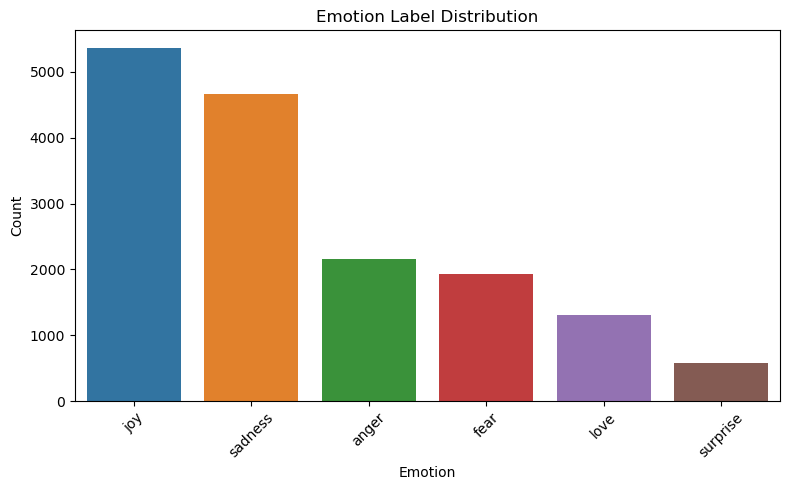

In [29]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='emotion', order=df['emotion'].value_counts().index)
plt.title("Emotion Label Distribution")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()  


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


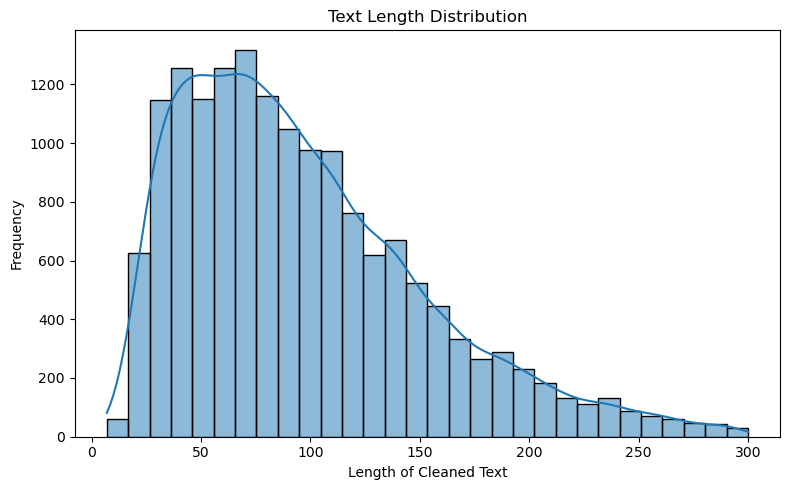

In [30]:
df['text_len'] = df['clean_text'].apply(len)
plt.figure(figsize=(8, 5))
sns.histplot(df['text_len'], bins=30, kde=True)
plt.title("Text Length Distribution")
plt.xlabel("Length of Cleaned Text")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show() 


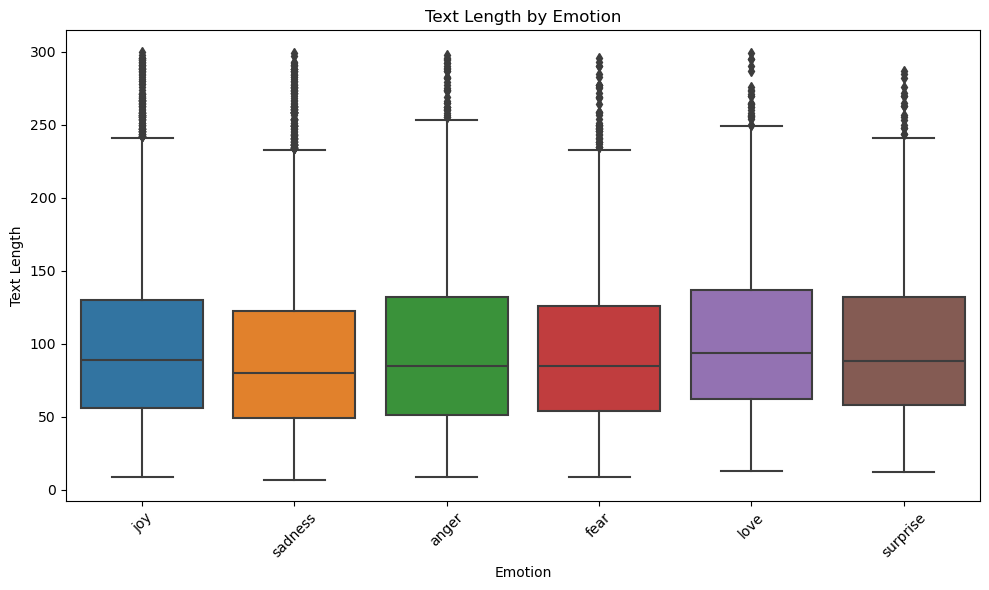

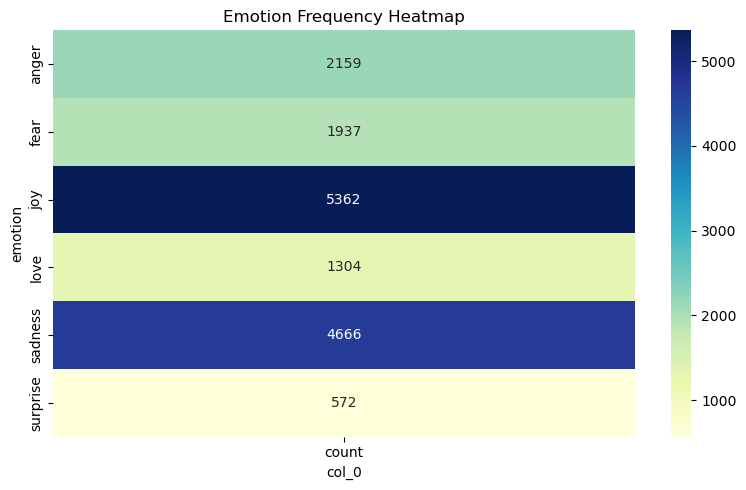

In [31]:
# Visualize emotion vs text length
plt.figure(figsize=(10, 6))
sns.boxplot(x='emotion', y='text_len', data=df, order=df['emotion'].value_counts().index)
plt.title("Text Length by Emotion")
plt.xlabel("Emotion")
plt.ylabel("Text Length")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()  


# Heatmap of class correlation 
emotion_counts = pd.crosstab(index=df['emotion'], columns='count')
plt.figure(figsize=(8, 5))
sns.heatmap(emotion_counts, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Emotion Frequency Heatmap")
plt.tight_layout()
plt.show() 


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters: {'clf__C': 10, 'tfidf__max_df': 0.7}
              precision    recall  f1-score   support

       anger       0.88      0.78      0.83       312
        fear       0.84      0.75      0.79       265
         joy       0.85      0.95      0.89       783
        love       0.85      0.70      0.77       218
     sadness       0.89      0.93      0.91       741
    surprise       0.80      0.58      0.67        81

    accuracy                           0.86      2400
   macro avg       0.85      0.78      0.81      2400
weighted avg       0.86      0.86      0.86      2400



<Figure size 800x600 with 0 Axes>

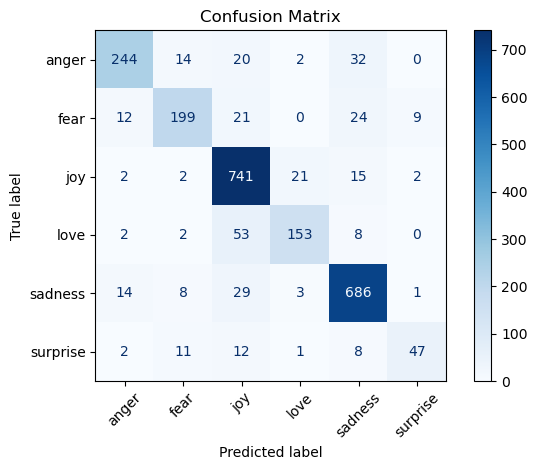

Top features for 'anger': ['bothered', 'resentful', 'offended', 'rushed', 'distracted', 'wronged', 'petty', 'greedy', 'dangerous', 'rude']
Top features for 'fear': ['shaky', 'apprehensive', 'intimidated', 'pressured', 'paranoid', 'reluctant', 'vulnerable', 'frantic', 'terrified', 'shaken']
Top features for 'joy': ['useful', 'precious', 'respected', 'innocent', 'clever', 'superior', 'determined', 'popular', 'satisfied', 'sincere']
Top features for 'love': ['loving', 'delicate', 'tender', 'longing', 'caring', 'lovely', 'naughty', 'supportive', 'sympathetic', 'nostalgic']
Top features for 'sadness': ['doomed', 'numb', 'gloomy', 'messy', 'unwelcome', 'damaged', 'disturbed', 'unfortunate', 'melancholy', 'dumb']
Top features for 'surprise': ['weird', 'overwhelmed', 'dazed', 'strange', 'funny', 'shocked', 'surprised', 'curious', 'amazed', 'impressed']


Enter text to detect emotion:  im feeling rather rotten so im not very ambitious right now



Predicted Emotion: sadness


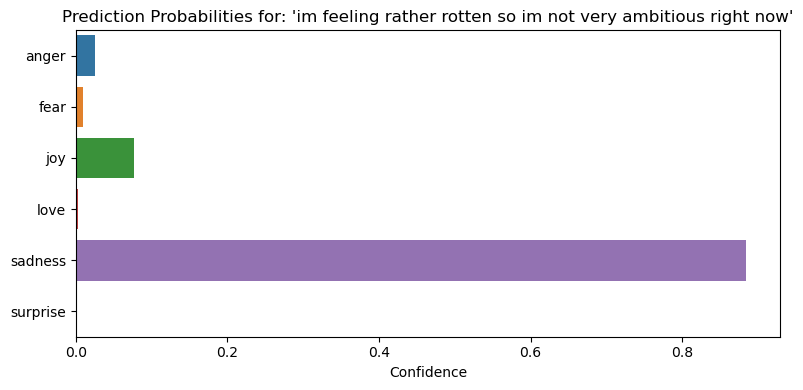

In [32]:
# Split 
X = df['clean_text']
y = df['emotion']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


base_model = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=5000)),
    ('clf', LogisticRegression(max_iter=300))
])


param_grid = {
    'tfidf__max_df': [0.7, 1.0],
    'clf__C': [0.1, 1, 10]
}

grid = GridSearchCV(base_model, param_grid, cv=3, scoring='accuracy', verbose=1)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
model = grid.best_estimator_

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.named_steps['clf'].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.named_steps['clf'].classes_)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()  # Display the plot without saving



clf = model.named_steps['clf']
tfidf = model.named_steps['tfidf']
feature_names = tfidf.get_feature_names_out()

for i, label in enumerate(clf.classes_):
    top10 = clf.coef_[i].argsort()[-10:]
    print(f"Top features for '{label}': {[feature_names[j] for j in top10]}")


joblib.dump(model, "emotion_model.pkl")

# Load and run demo
demo_text = input("Enter text to detect emotion: ")
loaded_model = joblib.load("emotion_model.pkl")
pred = loaded_model.predict([demo_text])[0]
print(f"\nPredicted Emotion: {pred}")

# Optional: plot confidence scores
probs = loaded_model.predict_proba([demo_text])[0]
labels = loaded_model.classes_
plt.figure(figsize=(8, 4))
sns.barplot(x=probs, y=labels)
plt.title(f"Prediction Probabilities for: '{demo_text}'")
plt.xlabel("Confidence")
plt.tight_layout()
plt.savefig("prediction_confidence.png")
plt.show()